In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import salem
import matplotlib.pyplot as plt

In [6]:
fchirps = '/media/mowglie/Fab1T/CHIRPS/chirps-v2.0.daily.peru.nc'
fdem = '/media/mowglie/Fab1T/CHIRPS/srtm_chirps.peru.nc'
fancash = '../../data/gis/Limite_departamental/BAS_LIM_DEPARTAMENTO.shp'

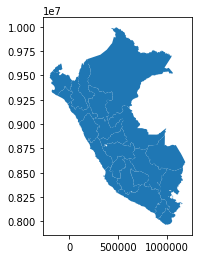

In [7]:
shdf = gpd.read_file(fancash)
shdf.plot();

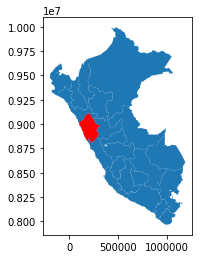

In [8]:
ac = shdf.loc[shdf.NOMBDEP == 'ANCASH']
f, ax = plt.subplots()
shdf.plot(ax=ax);
ac.plot(ax=ax, color='red');

In [9]:
ds = xr.open_dataset(fchirps).chunk({'time':365})
# Avoid the last year
ds = ds.sel(time=slice('1981', '2018'))

In [10]:
ds_dem = xr.open_dataset(fdem)

In [11]:
# This selects a box of data around the region
ds = ds.salem.subset(shape=ac, margin=2)
# This masks out the data which is not in the region
ds = ds.salem.roi(shape=ac)
# This masks out the data which is not above 1000m
ds = ds.where(ds_dem.topo > 1000)

In [13]:
# This can take some time
pcp = ds.mean(dim='time').precip.compute()

/home/mowglie/.pyvirtualenvs/py3/lib/python3.5/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


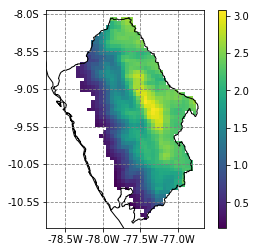

In [14]:
# Show what we've got
smap = ds.salem.get_map()
smap.set_shapefile(ac)
smap.set_data(pcp)
smap.visualize();

/home/mowglie/.pyvirtualenvs/py3/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


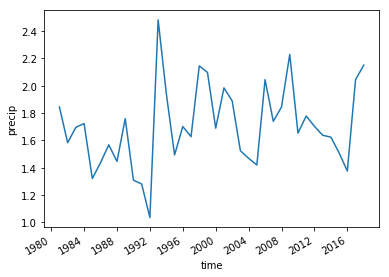

In [15]:
ts = ds.precip.mean(dim=['longitude', 'latitude']).compute()
ts.resample(time='AS').mean(dim='time').plot();

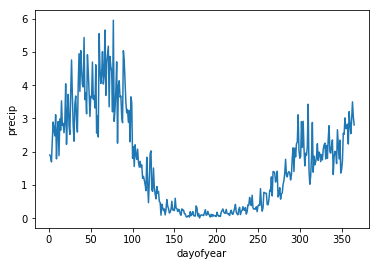

In [16]:
ts_doy = ts.groupby(ds['time.dayofyear']).mean().sel(dayofyear=slice(1, 365))
ts_doy.plot();

In [17]:
ts_5d_doy = ts.rolling(time=5, min_periods=1, center=True).mean(dim='time').groupby(ds['time.dayofyear']).mean().sel(dayofyear=slice(1, 365))
ts_31d_doy = ts.rolling(time=31, min_periods=1, center=True).mean(dim='time').groupby(ds['time.dayofyear']).mean().sel(dayofyear=slice(1, 365))

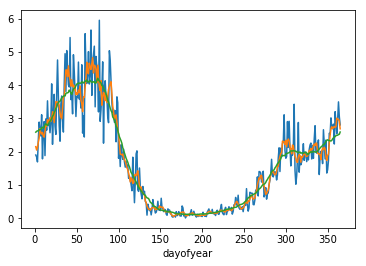

In [18]:
ts_doy.plot();
ts_5d_doy.plot();
ts_31d_doy.plot();

### Some freq statistics

In [29]:
# Take Huaraz
# We work in pandas for convenience
tsp = ds.sel(latitude=-9.53, longitude=-77.53, method='nearest').precip.to_series()

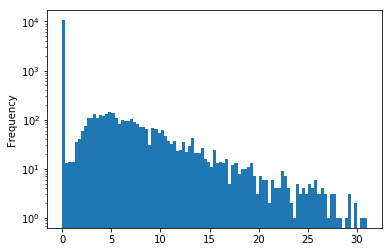

In [30]:
tsp.plot(kind='hist', bins=np.linspace(0, 31, 100));
plt.yscale('log');

In [31]:
classes = pd.cut(tsp, [0, 0.1, 0.5, 1, 2, 5, 10, 20, 51])
classes.value_counts()

(5.0, 10.0]     1318
(2.0, 5.0]      1085
(10.0, 20.0]     673
(20.0, 51.0]     134
(1.0, 2.0]        99
(0.5, 1.0]        25
(0.1, 0.5]         7
(0.0, 0.1]         0
Name: precip, dtype: int64

In [32]:
classes = pd.cut(tsp, [0, 1, 2, 5, 10, 20, 51])
classes.value_counts()

(5, 10]     1318
(2, 5]      1085
(10, 20]     673
(20, 51]     134
(1, 2]        99
(0, 1]        32
Name: precip, dtype: int64

In [33]:
# Here I could use fancy multi indexing but I'm lazy to google it up, so let's do it the simple way
bins = [0, 1, 2, 5, 10, 20, 51]
df = pd.DataFrame()
for b1, b2 in zip(bins[:-1], bins[1:]):
    df['{}-{}'.format(b1, b2)] = (tsp.where((tsp > b1) & (tsp < b2)) * 0 + 1).groupby(tsp.index.dayofyear).count()

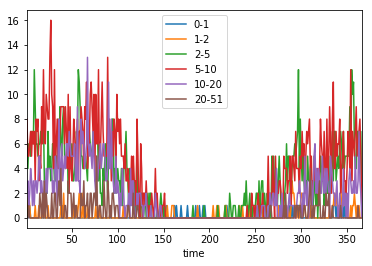

In [34]:
df.plot();